# Lab 2:  Feature Engineering

Feature Engineering is the process of transforming raw data into features/input variables that are easily digested by algorithms.  New Data Scientists often spend all of their time testing out various algorithms; however, the majority of accuracy gains generally stem from well crafted features.  In this Lab we will introduce the folling types of feature engineering:

1. [Feature pruning](#prune)   
1. [Temporal Features (month, year, etc)](#temporal)   
2. [Extracting features from strings](#strings)
3. [One-hot encoding / dummy variables](#onehote)
4. [Feature scaling](#scaling)
6. [Data Imputation / cleaning](#imputation)


While preforming Feature Engineering, it is critical to keep in mind the question that you are trying to answer.  For the purposes of this excercise, we will be using the KIVA dataset and will be trying to answering the following question:

*What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. In the next notebook, we will formalize this research question as a machine learning task. Our machine learning task will be to predict the loan amount that a borrower requests from KIVA using all the features we explore in this notebook.


We may not end up using all the features we create, but the process is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)
df = pd.read_csv("../data/df.csv", low_memory=False)
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,...,NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,...,NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,NaN,2017-06-08 00:30:05,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN
2,2,2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,...,"['Green', 'Earth Day Campaign']",Julie Keaton,892591.0,to buy a solar lantern.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:30:04,NaN,2017-06-08 00:30:03,2017-04-28 07:00:00,1,2017-04-28,2017,5,NaN
3,3,3,3,Used Clothing,0.0,False,

## 1. Feature Pruning
<a id='prune'></a>

No need to keep features that have zero variation.  Algorithms can only provide meaningful insights when there is variation in the featuers.  Given that we are preforming feature engineering for the purporse of feeding thse features into a machine learning algorithm, lets go ahead and remove all columns that only consist 1 or less unique values.

In [3]:
for col in df.columns:
    if df[col].unique().size==1:
        print("Dropping column: {0}".format(col))
        df = df.drop(col, axis=1)

Dropping column: image.template_id
Dropping column: journal_totals.bulkEntries
Dropping column: journal_totals.entries
Dropping column: location.country
Dropping column: location.country_code
Dropping column: location.geo.type
Dropping column: payments
Dropping column: partner_default_rate_note
Dropping column: partner_delinquency_rate_note
Dropping column: partner_image.template_id
Dropping column: partner_portfolio_yield_note
Dropping column: number_of_loans


## 2. Temporal Features
<a id='temporal'></a>
Time trends are very significant, and should not be neglected.  Most algorithms will not be able to make use of raw datetimes; however, will be able to find patterns in the data if they are informed which observations occur in a given year, on a weekday vs weekend, on a holiday, etc.

Before we are able to extract this meta data, let's convert the strings in the pandas dataframe to datetime objects. Luckily for us all time fields in this dataset have "_date" in their name.

Pandas is really adept at time series, and we will use pd.to_datetime to create pandas timestamps.
see a list of methods that can be applied to a pandas datetime. https://pandas.pydata.org/pandas-docs/version/0.21/api.html#id34

In [4]:
for col in [c for c in df.columns if "_date" in c]:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])

### .dt accessor
Pandas .dt accessor enables you to easily construct additional featuers based off of these datetimes

In [28]:
##  posted date features
df['posted_year']=df['posted_date'].dt.year
df['posted_month']=df['posted_date'].dt.month

## Time to fund is the funded date minus the posted date
## we add these fields because the homework question in the next notebook involves predicting time to fund
df['time_to_fund'] =df['funded_date'] - df['posted_date']
df['days_to_fund'] = df['time_to_fund'].dt.days

# expiration date features
## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_date'] =df['planned_expiration_date'] - df['posted_date']
df['days_to_expire'] = df['time_to_expire_date'].dt.days

## 3. Extracting features from strings
<a id='strings'></a>

String variables by themselves are generally not good inputs to algorithms; howevever, it is often possible to extract meaningful features from encoding the information that they contain.  Let's first find out which of our variables are string variables.  From there, let's review some of the variables and see if we can construct new features from the contents of these string variables.

To discover which of our DataFrame columns are string variables, we will utilize pandas dtypes method.  In pandas there are the following types:



|       dtype        |        Description        |
|--------------------|---------------------------|
|      float         | Numeric value with a decimal point.  If NaNs exist in col, pandas will default to float|
|        int         | Numerica values without decimal points. |
|       bool         | Column consisting of True and False|
| datetime64[ns, tz] | Objects which contain specific date and time |
|   timedelta[ns]    | Object which indicates time elapsed between two datetimes |
|     category       | Variables that can only have specified values |
|      object        | Pandas representation of string variables |

Let's now use pandas method get_dtype_counts to see what data types exist in the DataFrame, and then select_dtypes to view all columns with dtype == object

In [6]:
df.get_dtype_counts()

bool                2
datetime64[ns]     10
float64            20
int64              13
object             31
timedelta64[ns]     2
dtype: int64

In [7]:
df.select_dtypes(include=[object])

,activity,borrowers,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,location.geo.level,location.geo.pairs,location.town,name,sector,status,tags,terms.disbursal_currency,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.nonpayment,terms.repayment_interval,terms.scheduled_payments,themes,translator.byline,use,video.title,video.youtubeId,partner_countries,partner_name,partner_rating,partner_social_performance_strengths,partner_status,partner_url
0,Farming,"[{'first_name': 'Evaline', 'last_name': '', 'g...",['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,town,-0.583333 35.183333,litein,Evaline,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",KES,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,to purchase more tea leaves to sell to the tea...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLOF,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",active,http://www.eclof-kenya.org/
1,Furniture Making,"[{'first_name': 'Julias', 'last_name': '', 'ge...",['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,town,0.566667 34.566667,Bungoma,Julias,Manufacturing,fundraising,[],KES,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,to buy timber to make more furniture for his e...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLOF,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",active,http://www.eclof-kenya.org/
2,Home Energy,"[{'first_name': 'Rose', 'last_name': '', 'gend...",['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,town,0.516667 35.283333,Eldoret,Rose,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",KES,"[{'due_date': '2017-05-14T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...","['Green', 'Earth Day Campaign']",Julie Keaton,to buy a solar lantern.,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Juhudi Kilimo,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",active,http://www.juhudikilimo.com/
3,Used Clothing,"[{'first_name': 'Jane', 'last_name': '', 'gend...",['en'],"Jane was born in the 1980, and she is happily ...",NaN,NaN,NaN,town,0.566667 34.566667,Bungoma,Jane,Clothing,fundraising,[{'name': '#Eco-friendly'}],KES,"[{'due_date': '2017-05-08T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,to buy more clothes to meet the needs and tast...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLOF,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",active,http://www.eclof-kenya.org/
4,Farming,"[{'first_name': 'Alice', 'last_name': '', 'gen...",['en'],Alice (the woman pictured above in her small s...,NaN,NaN,NaN,town,1 38,Nandi Hills,Alice,Agriculture,fundraising,[{'name': '#Woman Owned Biz'}],KES,"[{'due_date': '2017-05-27T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",['Rural Exclusion'],NaN,"to buy farming inputs (fertilizers, pesticides...",NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Juhudi Kilimo,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",active,http://www.juhudikilimo.com/
5,Used Clothing,"[{'first_name': 'Clare', 'last_name': '', 'gen...",['en'],Clare is a married woman who is blessed with 2...,NaN,NaN,NaN,town,0.416667 34.25,Busia,Clare,Clothing,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Eco-...",KES,"[{'due_date': '2017-05-11T07:00:00Z', 'amount'...",shared,lender,Monthly,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,NaN,to buy more bales of clothes to grow her busin...,NaN,NaN,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",Kenya ECLO

The borrowers column looks like it may have some interesting information, but it is hard to tell since the string is cropped in the displayed DataFrame.  Lets take a look at an example value.

In [8]:
df['borrowers'][0]

"[{'first_name': 'Evaline', 'last_name': '', 'gender': 'F', 'pictured': True}]"

A very simple feature we can create is count for the number of borrowers listed.  In order to accomplish this we will leverage pandas [apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) method, which allows us to apply a lambda function to a specific column or collection of columns in order to create a new vector.  The provided lambda function is applied to each row in order to calculate the value of the corresponding row in the new vector.

In [9]:
df['num_borrowers'] = df['borrowers'].apply(lambda x: x.count("{"))
print(df[df['num_borrowers']>1]['num_borrowers'].iloc[0])
print(df[df['num_borrowers']>1]['borrowers'].iloc[0])

4
[{'first_name': 'Florence ', 'last_name': '', 'gender': 'F', 'pictured': True}, {'first_name': 'Wanjiru', 'last_name': '', 'gender': 'F', 'pictured': True}, {'first_name': 'Jane ', 'last_name': '', 'gender': 'F', 'pictured': True}, {'first_name': 'Pauline ', 'last_name': '', 'gender': 'F', 'pictured': True}]


Keeping in mind that the question that we are trying to answer is "What drives the loan amount requested by KIVA borrowers?" let's create a few variables that encode the information on the gender of the listed borrowers.

In order to do this, we will once again use pandas' `apply` method, but this time will we introduce a if-else statement inside the lambda function.  This will enable us to change the value of the resulting column vector based on whether the conditional returns True or False for each row.

In [10]:
df['gender']=df['borrowers'].apply(lambda x: "Male" if x.split("gender': '")[1][0]=='M' else "Female")
df['num_male'] = df['borrowers'].apply(lambda x: x.count('''M'''))
df['num_female'] = df['borrowers'].apply(lambda x: x.count('''F'''))
df['pct_female']=100.00*df['num_female']/(df['num_male']+df['num_female'])

Beyond gender, age and marital status could be key explanatory features for the requested loan amount.  These featuers will all be booleans, and in order to construct them we will use panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html).  This is a handy feature because it allows us to utilize a [regex](https://docs.python.org/2/library/re.html).

In [11]:
## Whether or not the borrower is widowed
#  Note the str.contains function
df['widowed'] = df['description.texts.en'].str.contains("widowed|widow", na=0)
## Whether or not the borrower is married
df['married'] = np.where(df['description.texts.en'].str.contains("married|husband|wife", na=0)==True, 1, 0)
## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter|mother|father|parents", na=0)

## 4. One-hot encoding
<a id='onehote'></a>

One-hot encoding is the process of converting either categorical or string data into a binary.  Let's practice one-hot encoding by converting the "tags" column into a set of binary features indicating whether or not a particular tag appears in a given row. 

In order to do this we will first need to convert the "tags" column into a list of strings, and then we will utilize pandas `get_dummies` method to create the binary features.  Binary features are often referred to in the statistics world as dummy features.

In [12]:
df['tag_list'] = df['tags'].apply(lambda x: [elem['name'] for elem in eval(x)])
tag_df = pd.get_dummies(df['tag_list'].apply(pd.Series).stack()).sum(level=0)
# TODO - Explain how merges work or better yet figure a way to avoid merging. - Jack 11/10/17
df = df.merge(tag_df, left_index = True, right_index = True, how = 'outer')

In [13]:
df[tag_df.columns] = df[tag_df.columns].fillna(0)

In [14]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'activity',
       'basket_amount', 'bonus_credit_eligibility', 'borrowers',
       'currency_exchange_loss_amount', 'description.languages',
       'description.texts.en',
       ...
       '#Technology', '#Tourism', '#Trees', '#Unique', '#Vegan', '#Widowed',
       '#Woman Owned Biz', 'user_favorite', 'volunteer_like',
       'volunteer_pick'],
      dtype='object', length=123)

## 5. Feature Scaling
<a id='scaling'></a>

We will not overwrite our dataframe with scaled values because the appropriate scaling technique depends on the algorithm.  These are the three most common feature scaling techniques:
1. Normalization
2. Standardization
3. Log-transform

Normalization is the process of rescaling the data from 0-1.  The formula for this approach is:

`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min` 

In [15]:
preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
normalized = min_max_scaler.fit_transform(df['loan_amount'].astype(np.float64).values.reshape(-1,1))[:,0]
print("Pre Scaling\tMin: {0}\t\t Max: {1}\tMean: {2}".format(df['loan_amount'].min(),df['loan_amount'].max(),df['loan_amount'].mean()))
print("Post Scaling\tMin: {0}\t Max: {1}\tMean: {2}".format(np.min(normalized),np.max(normalized),np.mean(normalized)))

Pre Scaling	Min: 25		 Max: 50000	Mean: 495.15978396835595
Post Scaling	Min: 0.0	 Max: 1.0	Mean: 0.00940789962918171


Standardization assumes normally distributed data (ie Gaussian) and scales the data so that it has a zero mean and unit variance.  Below is the formula
$${\dfrac{x - \bar x}{\sigma}}$$

In [16]:
standardized = preprocessing.scale(df['loan_amount'].astype(np.float64))
print("Post Scaling\tMin: {0}\t Max: {1}\tMean: {2}".format(np.min(standardized),np.max(standardized),np.mean(standardized)))

Post Scaling	Min: -0.6677683305270462	 Max: 70.31176555562773	Mean: -4.227848186002827e-17


From these values, it appears that our data has a skewed distribution, and is actually a good candidate for a log transform

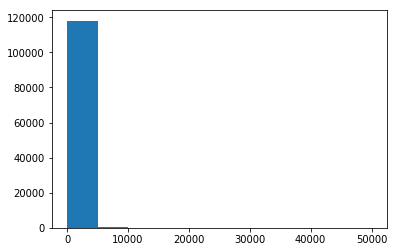

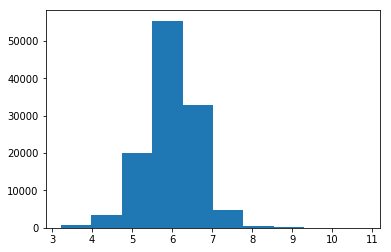

In [17]:
plt.hist(df['loan_amount'])
plt.show()
log_loan_amount = np.log(df['loan_amount'])
plt.hist(log_loan_amount)
plt.show()

## 6. Data Imputation / cleaning
<a id='imputation'></a>

Missing data can be informative, but it also will prevent many algorithms from training.  In order to enable our models to train while preserving the fact that some data is missing, we are going to:
1. Create a new column that indicates whether or not that column had missing data.
In pandas, missing data is either represented as NaN (Not a Number), or NaT (Not a Time).  While we look at our missing data, let's look at strings, numeric, and time objects separateley.

2. Imput missing data with the columns mean

First, let's have a quick refresher on dyptes in our DataFrame and create lists of all of the columns for specific data types.

In [18]:
df.get_dtype_counts()

bool                2
datetime64[ns]     10
float64            57
int64              17
object             35
timedelta64[ns]     2
dtype: int64

In [19]:
time_columns = df.select_dtypes(include=['datetime64','timedelta64']).columns
str_columns = df.select_dtypes(include=[object]).columns
numeric_columns = df.select_dtypes(exclude=[object,'datetime64','timedelta64']).columns

Now, let's use pandas `isnull` and `sum` functions to see how many observations of each column are missing.
Since there are a lot of columns in this DataFrame, let's restrict our returned DataFrame to columns which have 
missing data

In [20]:
df[time_columns].isnull().sum()[df[time_columns].isnull().sum()>0]

funded_date                     5612
planned_expiration_date        24913
funded_datetime                 5612
planned_expiration_datetime    24913
time_to_fund                    5612
time_to_expire_date            24913
dtype: int64

In [21]:
df[str_columns].isnull().sum()[df[str_columns].isnull().sum()>0]

description.texts.en                      4328
description.texts.es                    118313
description.texts.fr                    118313
description.texts.ru                    118312
location.town                             7909
terms.repayment_interval                117372
themes                                   89302
translator.byline                        35954
use                                       4327
video.title                             118240
video.youtubeId                         118240
partner_social_performance_strengths      4562
partner_url                               4067
dtype: int64

In [22]:
df[numeric_columns].isnull().sum()[df[numeric_columns].isnull().sum()>0]

basket_amount                                           117372
currency_exchange_loss_amount                           102626
terms.loss_liability.currency_exchange_coverage_rate      3869
translator.image                                         55299
video.id                                                118240
video.thumbnailImageId                                  118240
partner_portfolio_yield                                   6399
partner_profitability                                    11426
days_to_fund                                              5612
days_to_expire                                           24913
dtype: int64

With missing data, you should always check to see if there is a systemic difference between observations with and without missing data.

In [23]:
df[df['funded_date'].isnull()].describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,basket_amount,currency_exchange_loss_amount,funded_amount,id,image.id,lender_count,loan_amount,partner_id,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.currency_exchange_coverage_rate,terms.repayment_term,translator.image,video.id,video.thumbnailImageId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_delinquency_rate,partner_image.id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_profitability,partner_total_amount_raised,posted_year,posted_month,time_to_fund,days_to_fund,time_to_expire_date,days_to_expire,num_borrowers,num_male,num_female,pct_female,married,#Animals,#Biz Durable Asset,#Eco-friendly,#Elderly,#Fabrics,#Female Education,#First Loan,#Health and Sanitation,#Hidden Gem,#Inspiring Story,#Interesting Photo,#Job Creator,#Low-profit FP,#Married,#Orphan,#Parent,#Post-disbursed,#Refugee,#Repair Renew Replace,#Repeat Borrower,#Schooling,#Single,#Single Parent,#Supporting Family,#Sustainable Ag,#Team Guys Holding Fish,#Technology,#Tourism,#Trees,#Unique,#Vegan,#Widowed,#Woman Owned Biz,user_favorite,volunteer_like,volunteer_pick
count,5612.000000,5612.000000,5612.000000,944.000000,0.0,5612.000000,5.612000e+03,5.612000e+03,5612.000000,5612.000000,5612.000000,5.612000e+03,5612.000000,5611.000000,5612.000000,2.924000e+03,0.0,0.0,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5.612000e+03,5612.000000,5612.000000,5582.000000,5486.000000,5.612000e+03,5612.000000,5612.000000,0,0.0,5612,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.0,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.0,5612.000000,5612.0,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000,5612.000000
mean,30765.133108,30765.133108,30749.499822,0.185381,NaN,385.415182,1.008547e+06,2.055218e+06,10.128475,843.326800,184.409658,7.922746e+04,843.326800,0.100749,13.660549,1.253407e+06,NaN,NaN,3.524947,26.192926,0.253438,1.847719,4.896113,1.338869e+06,13.065587,15744.028689,25.528449,6.707499,7.234675e+06,2015.472737,6.155025,NaT,NaN,30 days 19:51:06.286528,30.827156,3.524947,2.202602,1.854241,42.690614,0.637919,0.080364,0.104954,0.232181,0.125267,0.010335,0.000178,0.071098,0.001604,0.002316,0.003564,0.007662,0.011226,0.005167,0.0,0.000178,0.673378,0.027619,0.000178,0.018354,0.398254,0.217569,0.022986,0.006771,0.039024,0.215431,0.0,0.194227,0.0,0.014433,0.004098,0.245367,0.002316,0.285460,0.226835,0.016928,0.024768
std,26456.942989,26456.942989,26440.703293,2.145937,NaN,531.319689,2.356791e+05,3.824353e+05,14.107743,980.483232,74.224811,6.506621e+04,980.483232,0.008620,5.180409,6.443653e+05,NaN,NaN,4.571800,20.324661,0.129567,1.904024,4.692570,5.986158e+05,9.904441,8396.494091,14.564497,13.916036,2.828987e+06,1.368669,3.201127,NaT,NaN,4 days 02:58:07.377590,4.123696,4.571800,3.056897,2.804787,41.670832,0.480645,0.271879,0.306521,0.422262,0.331051,0.101143,0.013349,0.257011,0.040018,0.048078,0.059596,0.087205,0.105366,0.071706,0.0,0.013349,0.469019,0.163894,0.013349,0.134238,0.489582,0.412630,0.149874,0.082016,0.193668,0.411158,0.0,0.395639,0.0,0.119279,0.063893,0.430343,0.048078,0.451673,0.418823,0.129013,0.155432
min,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,3.894270e+05,5.990510e+05,0.000000,75.000000,133.000000,3.600000e+03,75.000000,0.100000,8.000000,2.873300e+04,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,3.281970e+05,0.000000,0.000000,1.000000,-9.800000,0.000000e+00,2012.000000,1.000000,NaN,NaN,30 days 00:00:00,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [24]:
df[~df['funded_date'].isnull()].describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,basket_amount,currency_exchange_loss_amount,funded_amount,id,image.id,lender_count,loan_amount,partner_id,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.currency_exchange_coverage_rate,terms.repayment_term,translator.image,video.id,video.thumbnailImageId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_delinquency_rate,partner_image.id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_profitability,partner_total_amount_raised,posted_year,posted_month,time_to_fund,days_to_fund,time_to_expire_date,days_to_expire,num_borrowers,num_male,num_female,pct_female,married,#Animals,#Biz Durable Asset,#Eco-friendly,#Elderly,#Fabrics,#Female Education,#First Loan,#Health and Sanitation,#Hidden Gem,#Inspiring Story,#Interesting Photo,#Job Creator,#Low-profit FP,#Married,#Orphan,#Parent,#Post-disbursed,#Refugee,#Repair Renew Replace,#Repeat Borrower,#Schooling,#Single,#Single Parent,#Supporting Family,#Sustainable Ag,#Team Guys Holding Fish,#Technology,#Tourism,#Trees,#Unique,#Vegan,#Widowed,#Woman Owned Biz,user_favorite,volunteer_like,volunteer_pick
count,112704.000000,112704.000000,112704.000000,0.0,15690.000000,112704.000000,1.127040e+05,1.127040e+05,112704.000000,112704.000000,112704.000000,1.127040e+05,112704.000000,108836.000000,112704.000000,6.009300e+04,76.000000,7.600000e+01,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,1.127040e+05,112704.000000,112704.00000,106335.000000,101404.000000,1.127040e+05,112704.000000,112704.000000,112704,112704.000000,87791,87791.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000,112704.000000
mean,66109.853208,66109.853208,66073.740204,NaN,7.017447,477.822881,6.947179e+05,1.515306e+06,14.831293,477.823103,164.072934,3.992142e+04,477.823103,0.123258,13.451146,1.161574e+06,1291.697368,6.155305e+05,1.851301,30.217649,0.210486,3.919706,4.331362,1.504568e+06,11.452212,18295.78826,31.344201,2.127901,7.313707e+06,2013.463480,6.438343,8 days 00:14:11.703577,8.009858,31 days 07:28:44.527571,31.311626,1.851230,0.896011,1.266495,61.586456,0.639853,0.057469,0.041560,0.074709,0.042394,0.014915,0.001100,0.046041,0.007551,0.000932,0.002307,0.004845,0.004383,0.007001,0.000062,0.000355,0.273353,0.011384,0.000080,0.002786,0.097636,0.090565,0.007107,0.012280,0.013797,0.056227,0.000106,0.056209,0.000142,0.006442,0.002014,0.083981,0.005936,0.183303,0.126198,0.016406,0.024347
std,37895.720970,37895.720970,37874.473381,NaN,15.655207,682.798631,3.388865e+05,6.019246e+05,20.447522,682.798634,65.416106,4.263099e+04,682.798634,0.042248,8.267223,7.061583e+05,1027.999559,4.622450e+05,2.911028,16.900695,0.267191,10.717564,5.506963,6.013001e+05,10.934934,9455.86292,10.099698,11.091623,3.310323e+06,2.340923,3.575912,12 days 08:56:46.955887,12.372766,5 days 15:06:16.204496,5.629354,2.911034,1.675082,2.054580,43.203732,0.480045,0.232738,0.199583,0.262922,0.201488,0.121214,0.033152,0.209575,0.086567,0.030509,0.047975,0.069434,0.066060,0.083377,0.007881,0.018836,0.445683,0.106086,0.008936,0.052710,0.296824,0.286990,0.084004,0.110133,0.116649,0.230360,0.010318,0.230326,0.011914,0.080001,0.044834,0.277361,0.076816,0.386917,0.332074,0.127031,0.154125
min,16.000000,16.000000,16.000000,NaN,0.010000,25.000000,2.510000e+02,4.090000e+02,1.000000,25.000000,6.000000,2.500000e+01,25.000000,0.100000,2.000000,2.392400e+04,150.000000,2.975740e+05,1.000000,

Create columns that indicate whether or not data is missing.

In [25]:
for col in numeric_columns:
    df[col+'_na'] = pd.isnull(df[col])

Imput missing data with the mean

In [26]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

## THE END!

That is all for our feature engineering module!  Now that we have finished creating all of our features we can go ahead and explore them with some EDA!  The last step of this module is to save our results into a new csv

In [27]:
df.to_csv("../data/clean_data.csv")